In [5]:
with open("./data/causal_inference.txt", 'r') as f:
    text = f.readlines()

In [6]:
res = []
for t in text:
    res.append(list(map(int, t.strip('\n').split(" ")[:-1]))) # 最後空文字が入っている。
#     print(t.strip('\n').split(" ")[:-1])

# コロンビア大学で用いられているサンプルデータセット
http://www.cs.columbia.edu/~jebara/6998/hw2.pdf

- the 1st column is the chosen arm
- the 2nd column is binary reward 
- the remaining columns are the context features.

In [7]:
ds = pd.DataFrame(res)
ds.columns = ["arm", "reward"] + [f"feat_{i}" for i in range(100)]

In [16]:
X = ds.loc[:, "feat_0":].values
y = ds.loc[:, "reward"].values
arms = ds.loc[:,"arm"].values

### Reward の分布はこんな感じ

2.0588235294117645

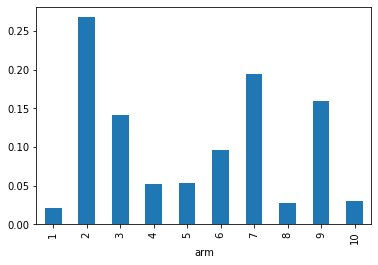

In [142]:
ds.groupby("arm").mean()["reward"].plot(kind="bar")
(ds.groupby("arm").mean()["reward"]*100).iloc[0]

In [143]:
#action = 3
# reward = 1 if y==2 else 0
class ContextualArms(object):
    def __init__(self,
                 n_action,
                 max_n_sim, 
                 X, y=None,
                 arms=None,
                 n_features=4,
                ):
        self.X = X
        self.y = y
        self.arms = arms
        self.n_action = n_action
        self.max_n_sim = max_n_sim
        self.t_count = 0
        self.current_samples_idxs = None
    def __len__(self):
        return self.n_action

    def reset(self):
        self.t_count = 0

    def draw(self):
        assert self.X is not None  and self.y is not None
        res = {}
        retrieve_indices = []
        for a in range(1, self.n_action+1):
            arm_a_idx_list = list(np.where(self.arms == a)[0])
            idx_a = random.sample(arm_a_idx_list, 1)
            retrieve_indices.append(idx_a)
        # FOR DEBUG
        #self.temp = retrieve_indices
        res = self.X[retrieve_indices, :]
        
        self.current_samples_idxs = list(itertools.chain.from_iterable(retrieve_indices))
        return res
    def get_reward(self, index):
        """
        rewardが0,1の値をとる確率変数でわかりずらかったため、試しにdetermined valued rewardを与える。
        """
        return (ds.groupby("arm").mean()["reward"]*100).iloc[index]
#         return self.y[self.current_samples_idxs[index]]

In [ ]:
import itertools, os
os.listdir()


In [145]:
Arms = ContextualArms(n_action=10, max_n_sim=100, X=X, y=y,arms=arms, n_features=X.shape[1])

In [148]:
import random

Arms.draw().shape


(10, 1, 100)

In [149]:
Arms.get_reward(1)

26.782077393075355

In [150]:
list(Arms.current_samples_idxs)

[4824, 5462, 7676, 3984, 9940, 1525, 5330, 4256, 161, 7385]

In [111]:
A = ds.loc[:, "feat_0":].values

In [112]:
class LinUCB(object):
    
    def __init__(self, sigma=1, sigma_0=1):
        
        pass

## LinUCB方策(アルゴリズム 7.1)

うーんよくわからんかった。
A_aはそれぞれの選択肢aにおける特徴量の分散行列で、p_atはpredicted valueのXX%信頼区間の上限値？かな？()
$\sqrt{x_{t,a}^TA_a^{-1}x_{t, a}}$、$theta$の分散が$V[\hat{\theta_a}] = \sigma^2 A^{-1}_a$となる事から求められる。
選んだ選択肢に関してだけ勾配降下法同じく更新してあげる。
次の期へ進む。

<img src="LinUBC.png" size=0.1>

In [168]:
d = 100
sigma=1; sigma_0=1
A_inv =sigma_0/sigma * np.eye(d); A_inv
b_t = np.zeros((d, 1))
alpha = 0.05
n_arms = 10
n_sim = 100000
history = []

In [169]:
# LinUCBアルゴリズム
for t in range(1, n_sim):
    mu_hat = np.zeros((n_arms, 1))
    # 3.
    theta = A_inv@b_t 
    # calc alpha_t
    alpha_t = alpha*np.sqrt(np.log(t))
    # 4. A[t]はa_itの転置ver
    
    # 各行動で以下のUCB scoreを計算する。
    # 各アームの特徴量を引く
    # shape : (10, 1, 100) 10 arms, (1, 100)の特徴量ベクトル
    # 1次元目にアーム１から10までの特徴量を順番に格納している。
    A_ = Arms.draw()
    for i in range(n_arms):
        mu_hat[i] = np.dot(A_[i], theta) + alpha_t*sigma*np.sqrt(A_[i]@A_inv@A_[i].T)
    i_star = mu_hat.argmax(0)[0]
    history.append(i_star)
    #5. スコア最大の行動 i*　を選択して報酬を観測する。
    reward = Arms.get_reward(index=i_star)
    #6.  A-inverse/ bの更新をする。
    second_term = (A_inv@A_[i_star].T@A_[i_star]@A_inv) / (1+A_[i_star]@A_inv@A_[i_star].T)
    A_inv = A_inv - second_term
    b_t += A_[i_star].T*reward    

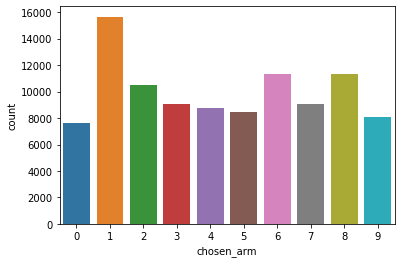

In [170]:
import seaborn as sns
sns.countplot(x="chosen_arm", data=pd.DataFrame(history, columns=["chosen_arm"]))

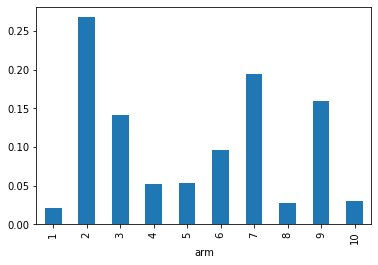

In [167]:
ds.groupby("arm").mean()["reward"].plot(kind="bar")

reward高いアームを選べるように学習できている！

### Thompson Sampling

$X_i(t) = \theta^Ta_{i,t} + \epsilon(t)$

$\epsilon(t) \sim N(., \sigma^2)$

今、$\theta$の事前分布を$\pi(\theta) = N(0, I_d)$ とすると、**各時刻に行動して報酬列を得た際の$\theta$の事後分布は...**

$\displaystyle \pi(\theta| \{i(s), X(s)\}^t_{s=1} )\propto \exp( - \frac{1}{2\sigma^2} (\theta - A_t^{-1}b_t)^TA_t(\theta - A_t^{-1}b_t))$

これは、$\theta$の事後分布が、$N(A^{-1}b, \sigma^2A^{-1})$であることをしている。

#### psuedo code

- input: $\sigma^2$
- param: $\sigma_0^2 > 0$

1. $A^{-1} \leftarrow \frac{\sigma_0^2}{\sigma^2} I_d, b \leftarrow 0_d$
2. **for t=1,2, ... ,T**
3. $\tilde{\theta}$を多変量正規分布$N(A^{-1}b, \sigma^2A^{-1})$から生成
4. $ i \leftarrow argmax_i \tilde{\theta}^T a_{i,t}$を選択して報酬X(t)を観測
5. LinUCBと同じA_inv, b_tの更新
6. **end for**


In [187]:
# (sigma**2*A_inv).shape


In [198]:
# np.exp(-np.diag((x - mu)@inv@(x - mu).T)/2.0) / (np.sqrt((2 * np.pi) ** n * det))
from scipy.stats import multivariate_normal


In [209]:
d = 100
sigma=1; sigma_0=1
A_inv =sigma_0/sigma * np.eye(d); A_inv
b_t = np.zeros((d, 1))
alpha = 0.05
n_arms = 10
n_sim = 100000
history = []

In [ ]:
#  Thompson sampling アルゴリズム
for t in range(1, n_sim):
    # 3. draw_theta
    theta = np.random.multivariate_normal(A_inv@b_t.flatten(), sigma**2*A_inv, size=1)
    # 4. A[t]はa_itの転置ver
    # 各アームの特徴量を引く
    # shape : (10, 1, 100) 10 arms, (1, 100)の特徴量ベクトル
    # 1次元目にアーム１から10までの特徴量を順番に格納している。
    A_ = Arms.draw()
    for i in range(n_arms):
        mu_hat[i] = np.dot(A_[i].ravel(), theta.ravel())
    i_star = mu_hat.argmax(0)[0]
    history.append(i_star)

    #5. スコア最大の行動 i*　を選択して報酬を観測する。
    reward = Arms.get_reward(index=i_star)
    #6.  A-inverse/ bの更新をする。
    second_term = (A_inv@A_[i_star].T@A_[i_star]@A_inv) / (1+A_[i_star]@A_inv@A_[i_star].T)
    A_inv = A_inv - second_term
    b_t += A_[i_star].T*reward    

In [ ]:
sns.countplot(x="chosen_arm", data=pd.DataFrame(history, columns=["chosen_arm"]))

## 以下、scraps

In [173]:
np.linalg.inv(A_inv)

array([[1.92409161e+08, 7.08901000e+05, 1.29623500e+06, ...,
        1.00425740e+07, 2.64960000e+04, 1.41127600e+06],
       [7.08901000e+05, 1.44640900e+06, 8.06063000e+05, ...,
        5.59300000e+04, 3.33080000e+04, 7.01218000e+05],
       [1.29623500e+06, 8.06063000e+05, 1.55844780e+07, ...,
        4.07379000e+05, 1.09270000e+04, 4.46388100e+06],
       ...,
       [1.00425740e+07, 5.59300000e+04, 4.07379000e+05, ...,
        5.78106100e+06, 2.54524000e+05, 2.90020000e+05],
       [2.64960000e+04, 3.33080000e+04, 1.09270000e+04, ...,
        2.54524000e+05, 2.94302000e+05, 1.55638000e+05],
       [1.41127600e+06, 7.01218000e+05, 4.46388100e+06, ...,
        2.90020000e+05, 1.55638000e+05, 2.53612000e+06]])

In [25]:
contextual.draw()

NameError: name 'contextual' is not defined

In [26]:
class EpsilonGreedyAgent():

    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.V = []

    def policy(self):
        coins = range(len(self.V))
        if random.random() < self.epsilon:
            return random.choice(coins)
        else:
            return np.argmax(self.V)

    def play(self, env):
        # Initialize estimation.
        N = [0] * len(env)
        self.V = [0] * len(env)

        env.reset()
        done = False
        rewards = []
        while not done:
            selected_coin = self.policy()
            reward, done = env.step(selected_coin)
            rewards.append(reward)

            n = N[selected_coin]
            coin_average = self.V[selected_coin]
            new_average = (coin_average * n + reward) / (n + 1)
            N[selected_coin] += 1
            self.V[selected_coin] = new_average

        return rewards


In [27]:
def main():
    env = ContextualBandit(n_action=3, max_n_sim=10000, simulation_dataset=(X, y))#CoinToss([0.1, 0.5, 0.1, 0.9, 0.1])
    epsilons = [0.0, 0.01, 0.2, 0.5, 0.8]
    game_steps = list(range(10, 310, 10))
    result = {}
    for e in epsilons:
        agent = EpsilonGreedyAgent(epsilon=e)
        means = []
        for s in game_steps:
            env.max_episode_steps = s
            rewards = agent.play(env)
            means.append(np.mean(rewards))
        result["epsilon={}".format(e)] = means
    result["coin toss count"] = game_steps
    result = pd.DataFrame(result)
    result.set_index("coin toss count", drop=True, inplace=True)
    result.plot.line(figsize=(10, 5))
    plt.show()

main()

NameError: name 'ContextualBandit' is not defined

## 結果
- 全てのarmの探索ができたagentは必ず1を返すarm(virginica)を選択できている。(epsilon=0.0を除く)
- 探索する割合が固定なので、期待値はそれぞれのagentで 1- epsilonの大きさを反映したものなっている。（？）

In [28]:
import numpy as np

### contextual Banditのagentを作成する。

In [99]:
pd.DataFrame(contextual.draw())

,0,1,2
0,5.1,6.4,7.1
1,3.5,3.2,3.0
2,1.4,4.5,5.9
3,0.2,1.5,2.1


In [138]:
# とりあえず作ってみた。
class LinUCB(object):
    def __init__(self, ContextualEnv):
        self.alpha =0.1
        self.sigma = 0.5
        pass
    
    def initialize(self, env):
        self.d = env.n_features
        self.inv_A = np.eye(self.d)
        self.b = np.zeros((self.d,1))

    def policy(self, env):
        # get action
        theta = self.inv_A@self.b
        # calculate UCBscore
        alpha = self.alpha * np.sqrt(np.log1p(env.t_count))
        a_t = pd.DataFrame(env.draw()).values.T # n_features * n_actions
        UCBscore = a_t@theta + np.diag(self.alpha*self.sigma*np.sqrt(a_t@self.inv_A@a_t.T)).reshape((-1, 1))
        print(UCBscore)
        action = np.argmax(UCBscore)
        print(action)   
        chosen_features = a_t.loc[:, action].values
        return action , chosen_features
    def update(self, features, reward):
        # woodbury's identity
        self.inv_A += (inv_A@features@features.T@inv_A)/(1 + features.T@inv_A@features)
        self.b = self.b + features*reward
        
    def play(self, env):
        # Initialize estimation.
        rewards = []
        # while not done:
        self.initialize()
        env.reset()
        action, features = self.policy(env)
        reward, done = env.step(action) 
        self.update(features, reward)
        rewards.append(reward)
        return rewards
    

In [127]:
agent = LinUCB()
agent.initialize(contextual)

In [128]:
agent.__dict__
self = agent

[[10.2]
 [15.6]
 [18.1]]
2


array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [107]:
# a_it ベクトルを生成するコード
a_t = pd.DataFrame(contextual.draw()).values.T # n_features * n_actions
# a_t (#actions * #features)

In [109]:
# stab
theta = np.ones((4, 1))
UCBscore = a_t@theta;print(UCBscore)
action = np.argmax(UCBscore)
action

[[10.2]
 [15.6]
 [18.1]]


2

In [111]:
np.diag(np.eye(4))

array([1., 1., 1., 1.])

In [10]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [68]:

random.sample(y[y==1].tolist(), k=1)

[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [ ]:
n_sim

In [1]:
# Import personalization data-set
 
# Info: https://d1ie9wlkzugsxr.cloudfront.net/data_irecsys_CARSKit/Movie_DePaulMovie/README.txt
 
data_url = "http://d1ie9wlkzugsxr.cloudfront.net/data_irecsys_CARSKit/Movie_DePaulMovie/ratings.csv" 

In [3]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv("ratings.csv")

In [6]:
df.head()

,userid,itemid,rating,Time,Location,Companion
0,1123,tt1499658,2,NaN,NaN,NaN
1,1123,tt0405422,4,NaN,NaN,NaN
2,1123,tt0109830,5,NaN,NaN,NaN
3,1123,tt0088763,3,NaN,NaN,NaN
4,1123,tt0133093,3,NaN,NaN,NaN


userid          0
itemid          0
rating          0
Time         1448
Location     1448
Companion    1448
dtype: int64


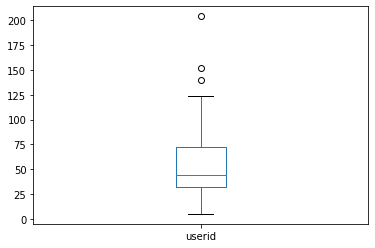

In [16]:
print(df.isna().sum(axis=0));df.userid.value_counts().plot(kind="box")

In [22]:
for col in ["Time", "Location", "Companion"]:
    print(df[col].value_counts())

Weekend    1845
Weekday    1750
Name: Time, dtype: int64
Cinema    1963
Home      1632
Name: Location, dtype: int64
Family     1343
Alone      1173
Partner    1079
Name: Companion, dtype: int64


# Linear Bandit Algorithm

- 他のマシンに関する情報を一切持たないケースを考えていたが、例えば、マシンごとの特徴量（*）から類似するマシンの報酬を推定する事ができるケースが現実問題で多々ある。

(*):筆者はやった事ないが、パチンコの台の傾きや、釘と釘の長さによって、当たりやすいかいなかが変わってくるらしい。

In [35]:
# https://github.com/icoxfog417/baby-steps-of-rl-ja/blob/master/EL/epsilon_greedy.py
class CoinToss():

    def __init__(self, head_probs, max_episode_steps=30):
        self.head_probs = head_probs
        self.max_episode_steps = max_episode_steps
        self.toss_count = 0

    def __len__(self):
        return len(self.head_probs)

    def reset(self):
        self.toss_count = 0

    def step(self, action):
        final = self.max_episode_steps - 1
        if self.toss_count > final:
            raise Exception("The step count exceeded maximum. \
                            Please reset env.")
        else:
            done = True if self.toss_count == final else False

        if action >= len(self.head_probs):
            raise Exception("The No.{} coin doesn't exist.".format(action))
        else:
            head_prob = self.head_probs[action]
            if random.random() < head_prob:
                reward = 1.0
            else:
                reward = 0.0
            self.toss_count += 1
            return reward, done
        
class EpsilonGreedyAgent():

    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.V = []

    def policy(self):
        coins = range(len(self.V))
        if random.random() < self.epsilon:
            return random.choice(coins)
        else:
            return np.argmax(self.V)

    def play(self, env):
        # Initialize estimation.
        N = [0] * len(env)
        self.V = [0] * len(env)

        env.reset()
        done = False
        rewards = []
        while not done:
            selected_coin = self.policy()
            reward, done = env.step(selected_coin)
            rewards.append(reward)

            n = N[selected_coin]
            coin_average = self.V[selected_coin]
            new_average = (coin_average * n + reward) / (n + 1)
            N[selected_coin] += 1
            self.V[selected_coin] = new_average

        return rewards



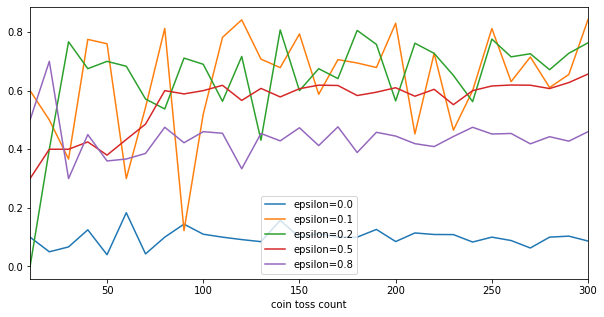

In [36]:
import random
import pandas as pd
import matplotlib.pyplot as plt

def main():
    env = CoinToss([0.1, 0.5, 0.1, 0.9, 0.1])
    epsilons = [0.0, 0.1, 0.2, 0.5, 0.8]
    game_steps = list(range(10, 310, 10))
    result = {}
    for e in epsilons:
        agent = EpsilonGreedyAgent(epsilon=e)
        means = []
        for s in game_steps:
            env.max_episode_steps = s
            rewards = agent.play(env)
            means.append(np.mean(rewards))
        result["epsilon={}".format(e)] = means
    result["coin toss count"] = game_steps
    result = pd.DataFrame(result)
    result.set_index("coin toss count", drop=True, inplace=True)
    result.plot.line(figsize=(10, 5))
    plt.show()

main()

# Construct Agents

# LinUBC

In [7]:
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# get_dummies, non idempotent processing
# df = pd.concat([df, pd.get_dummies(df[["Time", "Location", "Companion"]])], axis=1)

In [3]:
# dummies = pd.get_dummies(df[["Time", "Location", "Companion"]])

# Get Interactions

In [95]:
pe = PolynomialFeatures(2, interaction_only=True)

interactions = pe.fit_transform(dummies, )

generated_columns = pe.get_feature_names()

assert  all(dummies.iloc[:, 1] == interactions[:, 2])

corresp_cols ={f"x{i}": col for i , col in enumerate(dummies.columns)}

# generated_columns 
for k,v in corresp_cols.items():
    generated_columns = [col.replace(k, v) for col in generated_columns]
generated_columns

In [12]:
dummies

,Time_Weekday,Time_Weekend,Location_Cinema,Location_Home,Companion_Alone,Companion_Family,Companion_Partner
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
5038,0,1,0,1,0,0,1
5039,0,1,0,1,0,0,1
5040,0,1,0,1,0,0,1
5041,0,1,0,1,0,0,1


In [40]:
# features of all arms
non_features_cols = ["userid", "itemid", "rating"]
df.columns.difference(non_features_cols).to_list()

['Companion',
 'Companion_Alone',
 'Companion_Family',
 'Companion_Partner',
 'Location',
 'Location_Cinema',
 'Location_Home',
 'Time',
 'Time_Weekday',
 'Time_Weekend']

In [17]:
# rewards vector
rewards = df.rating.values.astype(np.float)
features = dummies.values
f_names = dummies.columns.to_list()

In [18]:
rewards

array([2., 4., 5., ..., 1., 1., 1.])

In [21]:
# t:time (各ユーザごとにpartitionきる？)
d = features.shape[1]

In [25]:
A_a = np.eye(d)
b_a = np.zeros((d, 1))

In [42]:
alpha = 0.3

In [31]:
theta_a = np.linalg.inv(A_a)@b_a
p_ta = features@theta_a + alpha*np.sqrt(np.diag(features@np.linalg.inv(A_a)@features.T).reshape((-1, 1)))

In [34]:
(features@theta_a).shape

(5043, 1)

In [45]:
p_ta.shape

(5043, 1)

# サンプルデータが見つからない...!

- どうしようーってなっていたやさき、そういえばバンディットって「自分が選択したあーむ以外の報酬が見れないだけで問題設定はマルチラベリング問題のオンライン学習と同義」、と本多さんの本に書いてあったことを思い出した。
    https://github.com/david-cortes/contextualbandits/blob/master/example/online_contextual_bandits.ipynb
- irisを活用する！

In [4]:
from sklearn.datasets import load_iris 

In [5]:
# X, y = load_iris(True)

In [11]:
X, y = load_iris(return_X_y=True)

In [13]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [20]:
# irisデータからbaditの文脈に合うようにsamplingできるクラスを作成する。
df_cps1 = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls.dta')
df_cps3 = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls3.dta')
df_nsw = pd.read_stata('https://users.nber.org/~rdehejia/data/nsw_dw.dta')

In [22]:
df_cps1.describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,15992.0,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000
mean,0.0,33.225239,12.027514,0.073537,0.072036,0.711731,0.295835,14016.800781,13650.803711,14846.660156
std,0.0,11.045216,2.870846,0.261024,0.258556,0.452971,0.456432,9569.795898,9270.403320,9647.391602
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,24.000000,11.000000,0.000000,0.000000,0.000000,0.000000,4403.452393,4398.823242,5669.298096
50%,0.0,31.000000,12.000000,0.000000,0.000000,1.000000,0.000000,15123.580078,14557.110352,16421.974609
75%,0.0,42.000000,13.000000,0.000000,0.000000,1.000000,1.000000,23584.179688,22923.736816,25564.669922
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320312,25243.550781,25564.669922


In [32]:
# df_cps3.describe()
df_nsw.columns
regressors_columns =  ['treat', 'age', 'education', 'black', 'hispanic', 'married', 'nodegree',]
target_column = 're78'
X = df_nsw[regressors_columns].values
y = df_nsw[target_column].values